In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [5]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

In [13]:
A=df_train.as_matrix()
X_train=A[:,:-2]
t_train=A[:,-1]
N_tr=np.shape(X_train)[0]
D=np.shape(X_train)[1]

### Normalize features

In [14]:
moy = np.zeros(D)
sigma = np.zeros(D)
for k in range(0,D): # D columns of entries
    moy[k] = np.mean(X_train[:,k])
    sigma[k] = np.std(X_train[:,k])
    X_train[:,k] = (X_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1

t_mean= np.mean(t_train)
t_sig = np.std(t_train)
t_train_mf = (t_train-t_mean)/t_sig # mean-free target vector of training set

In [15]:
# 1. Autocovariance
X_train_trans = np.transpose(X_train)
autocov = 1.0/N_tr*np.dot(X_train_trans,X_train)

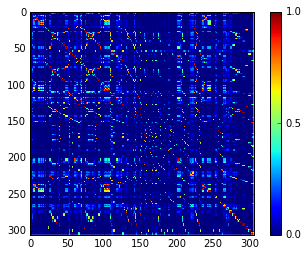

In [16]:
fig=plt.figure()
cax=plt.imshow(autocov, interpolation='none',clim=[0,1],cmap='jet')
fig.colorbar(cax, ticks=[0, 0.5, 1])

In [78]:
Xdf_tr = df_train.iloc[:,1:-1]
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 20 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]

selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]

from sklearn import preprocessing
#X_tr = df_train[features].as_matrix()
X_tr = preprocessing.scale(df_train[features].as_matrix())
t_tr = df_train['TARGET'].as_matrix()

Chi2 & F_classif selected 46 features


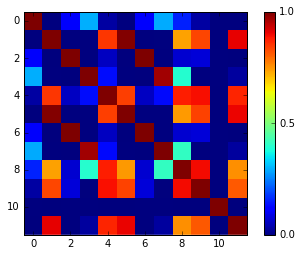

In [70]:
autocov = 1.0/N_tr*np.dot(np.transpose(X_tr),X_tr)

fig2=plt.figure()
cax=plt.imshow(autocov, interpolation='none',clim=[0,1],cmap='jet')
fig2.colorbar(cax, ticks=[0, 0.5, 1])

['var15', 'ind_var5', 'ind_var8_0', 'ind_var13', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var13', 'num_var30', 'num_var42', 'var36', 'num_meses_var5_ult3']


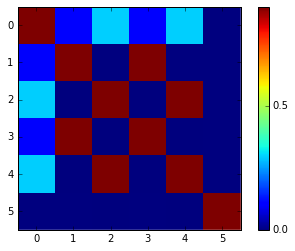

In [62]:
ids_out=[1,4,5,8,9,11]
autocov_clean = np.delete(autocov, ids_out, 0)
autocov_clean = np.delete(autocov_clean, ids_out, 1)
print features

fig2=plt.figure()
cax=plt.imshow(autocov_clean, interpolation='none',clim=[0,0.9],cmap='jet')
fig2.colorbar(cax, ticks=[0, 0.5, 1])

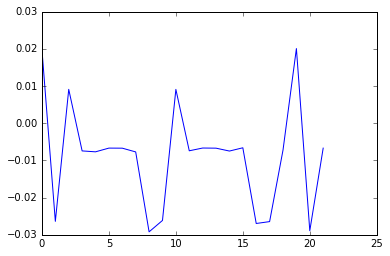

In [43]:
plt.plot(cov)

In [73]:
np.shape(autocov)

(12, 12)

In [109]:
Xdf=pd.DataFrame(X_tr)
corrFloat = Xdf.corr()
print ("The shape of correlation coefficient matrix:", corrFloat.shape)

('The shape of correlation coefficient matrix:', (46, 46))


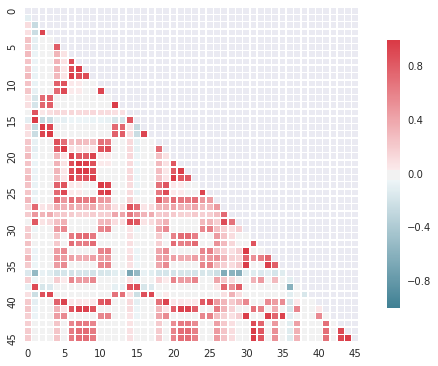

In [110]:
import seaborn as sns
# Below code URL: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
mask = np.zeros_like(corrFloat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrFloat, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

In [111]:

# threshold is arbitrary, but in this example threshold = +/-0.8 (Pearson's correlation coefficient)

# check the number of unique combinations of 2 variables
import itertools
pairs = list(itertools.combinations(Xdf.columns, 2))
print ("Variables pairs:", len(pairs))

hiCor = []
hiCorCounter = 0
for i in range(Xdf.shape[1]):
    for j in range(0, i):
        if corrFloat[Xdf.columns[i]][j] > 0.8 or Xdf[Xdf.columns[i]][j] < -0.8:
            #hiCor.append(Xdf.index[j])
            hiCor.append(Xdf.columns[j]) #list(Xdf.columns.values)
        hiCorCounter += 1

# get unique values from the list
hiCor = list(set(hiCor))

print ("Checked pairs:", hiCorCounter)
print ("Columns to be removed due to high correlation:", len(hiCor))

Xdf.drop(hiCor, axis=1, inplace=True)

print ("New combi shape:", Xdf.shape)

('Variables pairs:', 1035)
('Checked pairs:', 1035)
('Columns to be removed due to high correlation:', 37)
('New combi shape:', (76020, 9))


In [112]:
corrFloat = Xdf.corr()
print ("The shape of correlation coefficient matrix:", corrFloat.shape)

('The shape of correlation coefficient matrix:', (9, 9))


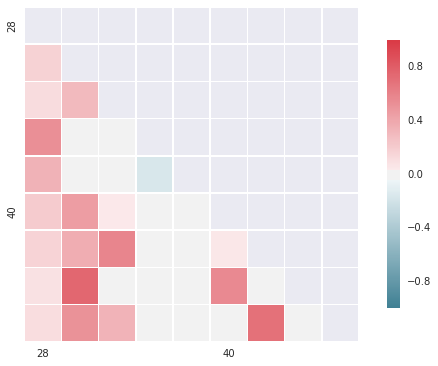

In [113]:
import seaborn as sns
# Below code URL: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
mask = np.zeros_like(corrFloat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrFloat, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

In [88]:
Xdf

,28,34,37,38,39,40,41,42,45
0,-1.150328,-0.217091,-0.137355,-1.524332,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
1,-0.104375,-0.212330,5.292554,-0.754459,-0.160058,-0.209259,5.968551,-0.123948,-0.141447
2,-0.104375,-0.217043,-0.137355,0.785287,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
3,1.987531,-0.215970,-0.137355,0.015414,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
4,-0.104375,1.925350,-0.137355,0.785287,-0.160058,1.841249,-0.203516,2.284085,-0.150862
5,-1.150328,-0.217091,-0.137355,-1.524332,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
6,-0.104375,-0.217043,-0.137355,0.785287,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
7,-0.104375,-0.217043,-0.137355,0.015414,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
8,-1.150328,-0.217091,-0.137355,-1.524332,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
9,-0.104375,-0.217043,-0.137355,0.015414,-0.160058,-0.209259,-0.203516,-0.123948,-0.150862
